## Import Libraries

In [49]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import os

print("Libraries imported successfully.")

Libraries imported successfully.


## Configuration

Set Monte Carlo parameters and file paths.

In [50]:
# Configuration
from pathlib import Path
n_samples = 1000000           # Number of Monte Carlo samples

# Project-root based results directory (Drake-specific outputs go here)
PROJECT_ROOT = Path.cwd().parent
results_dir = PROJECT_ROOT / 'Results' / 'Drake'
results_dir.mkdir(parents=True, exist_ok=True)

# Input JSON with G-star count (produced by g_star_spiral_model.ipynb)
json_input = PROJECT_ROOT / 'Results' / 'g_star_results.json'
# Output JSON for Drake results (placed in Drake subfolder)
json_output = results_dir / 'g_drake_results_notebook.json'

n_stars_override = None      # Set to override JSON value (leave None to use JSON)

print(f"Configuration:")
print(f"  N_samples: {n_samples}")
print(f"  Input JSON: {json_input}")
print(f"  Output JSON: {json_output}")
print(f"  Results directory: {results_dir}")
print(f"  N_stars override: {n_stars_override}")

Configuration:
  N_samples: 1000000
  Input JSON: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_results.json
  Output JSON: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\Drake\g_drake_results_notebook.json
  Results directory: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\Drake
  N_stars override: None


## Provenance & Reproducibility

**Source of inputs:** `Results/g_star_results.json` (this file is read at runtime to set `N_stars`; keys include `N_expected_arms` and/or `N_expected_shell`).

**Notes:**
- The notebook will prefer `N_expected_arms` if present; you can override the value by setting `n_stars_override` in the configuration cell.
- If you install new packages (e.g., `plotly`, `kaleido`) **restart the kernel** before running the interactive export cells.
- Reproducible run order: 1) Run the **Configuration** and **Helper Functions** cells; 2) Run **Load G-Star Count**; 3) Run the sampling, summary, visualization, and export cells in sequence.
- Outputs are saved under the `Results/` directory: summary JSON (`g_drake_results_notebook.json`), distribution figure (`g_drake_estimate_distributions.png`), and sensitivity outputs (`g_drake_sensitivity.json`, `g_drake_sensitivity.png`).

**Example:** After running the notebook, `N_stars` is printed (e.g., `Using N_stars = 1.604e+06`), and the summary JSON indicates the values used for downstream calculations.

## Helper Functions

In [51]:
def loguniform(low, high, size=None):
    """Sample from log-uniform distribution."""
    return np.exp(np.random.uniform(math.log(low), math.log(high), size=size))

def quantile_summary(x):
    """Compute quantile summary: 0.1%, 1%, 5%, 16%, 50%, 84%, 95%, 99%, 99.9%."""
    return np.quantile(x, [0.001, 0.01, 0.05, 0.16, 0.5, 0.84, 0.95, 0.99, 0.999])

print("Helper functions defined.")

Helper functions defined.


## Load G-Star Count

Load the estimated number of G-type stars from JSON file or use override.

In [52]:
# Load N_stars from JSON
N_stars = None

if n_stars_override is not None:
    N_stars = float(n_stars_override)
    print(f"Using override: N_stars = {N_stars:.3e}")
else:
    # allow a few reasonable fallbacks in case working directory differs
    if not json_input.exists():
        alt = Path.cwd() / 'Results' / json_input.name
        if alt.exists():
            json_input = alt
        else:
            alt2 = Path.cwd().parent / 'Results' / json_input.name
            if alt2.exists():
                json_input = alt2

    if json_input.exists():
        with json_input.open('r') as f:
            data = json.load(f)
        # Prefer density-weighted arms estimate if present
        if 'N_expected_arms' in data:
            N_stars = float(data['N_expected_arms'])
            source = 'N_expected_arms (arms)'
        elif 'N_expected_shell' in data:
            N_stars = float(data['N_expected_shell'])
            source = 'N_expected_shell (total)'
        else:
            raise KeyError(f"JSON at {json_input} does not contain expected keys")
        print(f"Loaded from {json_input}: N_stars = {N_stars:.3e} ({source})")
    else:
        raise FileNotFoundError(f"No JSON found at {json_input} (tried fallbacks) and --n-stars not provided")

print(f"\nUsing N_stars = {N_stars:.3e} for Drake calculation")

Loaded from c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\g_star_results.json: N_stars = 1.604e+06 (N_expected_arms (arms))

Using N_stars = 1.604e+06 for Drake calculation


## Fixed Drake Parameters

Define constants and assumptions for the Drake equation.

In [53]:
# Fixed parameters
t_star = 1.0e10  # G-type main-sequence lifetime in years (~10 Gyr)
fp = 1.0         # Fraction of stars with planets (optimistic: all stars)
ne = 0.1         # Number of potentially habitable planets per star (order-of-magnitude)

print("Fixed Drake Parameters:")
print(f"  t_star (G-star lifetime) = {t_star:.2e} years (~10 Gyr)")
print(f"  fp (stars with planets) = {fp} (optimistic)")
print(f"  ne (habitable planets/star) = {ne}")

Fixed Drake Parameters:
  t_star (G-star lifetime) = 1.00e+10 years (~10 Gyr)
  fp (stars with planets) = 1.0 (optimistic)
  ne (habitable planets/star) = 0.1


## Prior Distributions

Sample uncertain Drake factors from prior distributions:
- $f_l$: fraction of habitable planets with life → log-uniform [$10^{-6}$, 1]
- $f_i$: fraction of life-bearing planets with intelligence → log-uniform [$10^{-6}$, 1]
- $f_c$: fraction of intelligent species that become technological → uniform [0.01, 1]
- $L$: civilization lifetime in years → log-uniform [$10^2$, $10^8$]

In [54]:
# Sample priors
rng = np.random.default_rng()

f_l = loguniform(1e-6, 1.0, size=n_samples)  # fraction with life
f_i = loguniform(1e-6, 1.0, size=n_samples)  # fraction with intelligence
f_c = rng.uniform(0.01, 1.0, size=n_samples)  # fraction communicative
L = loguniform(1e2, 1e8, size=n_samples)    # civilization lifetime (years)

print(f"Sampled {n_samples} sets of Drake priors:")
print(f"  f_l:  log-uniform [1e-6, 1.0]")
print(f"  f_i:  log-uniform [1e-6, 1.0]")
print(f"  f_c:  uniform [0.01, 1.0]")
print(f"  L:    log-uniform [1e2, 1e8] years")

Sampled 1000000 sets of Drake priors:
  f_l:  log-uniform [1e-6, 1.0]
  f_i:  log-uniform [1e-6, 1.0]
  f_c:  uniform [0.01, 1.0]
  L:    log-uniform [1e2, 1e8] years


## Compute Drake Probabilities

Calculate per-star probability and population-level probability using vectorized operations.

In [55]:
# Per-star probability: p = fp * ne * f_l * f_i * f_c * (L / t_star)
p = fp * ne * f_l * f_i * f_c * (L / t_star)

# Probability at least one civilization in N_stars
# Use stable computation: p_any = 1 - exp(N * log1p(-p))
log1p_minus_p = np.log1p(-p)
exponent = N_stars * log1p_minus_p
p_any = 1.0 - np.exp(exponent)

# Expected number of civilizations
expected_n_civ = N_stars * p

print(f"Computed Drake probabilities for {n_samples} samples")
print(f"  Per-star p: [{p.min():.3e}, {p.max():.3e}]")
print(f"  P(at least one): [{p_any.min():.3e}, {p_any.max():.3e}]")
print(f"  Expected civilizations: [{expected_n_civ.min():.3e}, {expected_n_civ.max():.3e}]")

Computed Drake probabilities for 1000000 samples
  Per-star p: [4.441e-23, 6.255e-04]
  P(at least one): [1.110e-16, 1.000e+00]
  Expected civilizations: [7.123e-17, 1.003e+03]


## Summary Statistics

In [56]:
# Compute quantiles
p_quantiles = quantile_summary(p)
p_any_quantiles = quantile_summary(p_any)
expected_n_civ_quantiles = quantile_summary(expected_n_civ)

# Create summary dictionary
summary = {
    'N_stars_used': float(N_stars),
    'n_samples': n_samples,
    'per_star_p_quantiles': p_quantiles.tolist(),
    'per_star_p_mean': float(np.mean(p)),
    'per_star_p_median': float(np.median(p)),
    'p_any_quantiles': p_any_quantiles.tolist(),
    'p_any_mean': float(np.mean(p_any)),
    'p_any_median': float(np.median(p_any)),
    'expected_n_civ_quantiles': expected_n_civ_quantiles.tolist(),
    'expected_n_civ_mean': float(np.mean(expected_n_civ)),
    'expected_n_civ_median': float(np.median(expected_n_civ)),
    'priors': {
        'fp': fp,
        'ne': ne,
        'f_l_range': [1e-6, 1.0],
        'f_i_range': [1e-6, 1.0],
        'f_c_range': [0.01, 1.0],
        'L_range_years': [1e2, 1e8],
        't_star_years': t_star
    }
}

# Display summary
print("\n" + "="*70)
print("SUMMARY: G-Type Drake Equation Monte Carlo")
print("="*70)
print(f"\nNumber of G-stars: {summary['N_stars_used']:.3e}")
print(f"Monte Carlo samples: {summary['n_samples']}")
print(f"\nPer-Star Probability (median): {summary['per_star_p_median']:.3e}")
print(f"Per-Star Probability (mean):   {summary['per_star_p_mean']:.3e}")
print(f"\nP(at least one civilization):")
print(f"  Median: {summary['p_any_median']:.3e}")
print(f"  Mean:   {summary['p_any_mean']:.3e}")
print(f"\nExpected Number of Civilizations:")
print(f"  Median: {summary['expected_n_civ_median']:.3e}")
print(f"  Mean:   {summary['expected_n_civ_mean']:.3e}")
print("\n" + "="*70)


SUMMARY: G-Type Drake Equation Monte Carlo

Number of G-stars: 1.604e+06
Monte Carlo samples: 1000000

Per-Star Probability (median): 3.832e-13
Per-Star Probability (mean):   1.987e-07

P(at least one civilization):
  Median: 6.148e-07
  Mean:   2.499e-02

Expected Number of Civilizations:
  Median: 6.148e-07
  Mean:   3.188e-01



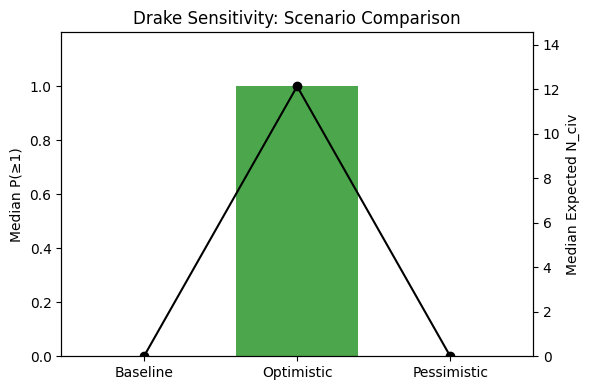

Saved sensitivity JSON to: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\Drake\g_drake_sensitivity.json
Saved sensitivity figure to: c:\Users\babak\Desktop\Innovation\Sumerian Kings\Results\Drake\g_drake_sensitivity.png


In [57]:
# Sensitivity analysis across prior choices
import json
import matplotlib.pyplot as plt
from pathlib import Path

sensitivity_results = {}
scenarios = {
    'Baseline': {
        'n_samples': 200_000,
        'fl_sampler': lambda n: loguniform(1e-6, 1.0, size=n),
        'fi_sampler': lambda n: loguniform(1e-6, 1.0, size=n),
        'fc_sampler': lambda n: rng.uniform(0.01, 1.0, size=n),
        'L_sampler': lambda n: loguniform(1e2, 1e8, size=n)
    },
    'Optimistic': {
        'n_samples': 200_000,
        'fl_sampler': lambda n: rng.uniform(1e-2, 1.0, size=n),
        'fi_sampler': lambda n: rng.uniform(1e-2, 1.0, size=n),
        'fc_sampler': lambda n: rng.uniform(0.1, 1.0, size=n),
        'L_sampler': lambda n: loguniform(1e6, 1e8, size=n)
    },
    'Pessimistic': {
        'n_samples': 200_000,
        'fl_sampler': lambda n: loguniform(1e-6, 1e-4, size=n),
        'fi_sampler': lambda n: loguniform(1e-6, 1e-4, size=n),
        'fc_sampler': lambda n: rng.uniform(0.01, 0.1, size=n),
        'L_sampler': lambda n: loguniform(1e2, 1e4, size=n)
    }
}

for name, cfg in scenarios.items():
    n = cfg['n_samples']
    fl_s = cfg['fl_sampler'](n)
    fi_s = cfg['fi_sampler'](n)
    fc_s = cfg['fc_sampler'](n)
    L_s = cfg['L_sampler'](n)

    p_s = fp * ne * fl_s * fi_s * fc_s * (L_s / t_star)
    p_s = np.clip(p_s, 0.0, 1.0 - 1e-30)
    p_any_s = 1.0 - np.exp(N_stars * np.log1p(-p_s))
    expected_n_civ_s = N_stars * p_s

    sensitivity_results[name] = {
        'per_star_p_quantiles': quantile_summary(p_s).tolist(),
        'p_any_quantiles': quantile_summary(p_any_s).tolist(),
        'expected_n_civ_quantiles': quantile_summary(expected_n_civ_s).tolist(),
        'per_star_p_mean': float(np.mean(p_s)),
        'p_any_mean': float(np.mean(p_any_s)),
        'expected_n_civ_mean': float(np.mean(expected_n_civ_s))
    }

# Ensure Results directory exists and save results
# results_dir configured in the Configuration cell (PROJECT_ROOT / 'Results' / 'Drake')
results_dir.mkdir(parents=True, exist_ok=True)

sens_path = results_dir / 'g_drake_sensitivity.json'
with sens_path.open('w') as f:
    json.dump(sensitivity_results, f, indent=2)

# Plot comparison (median of P(>=1) and Expected N_civ)
names = list(sensitivity_results.keys())
p_any_meds = [sensitivity_results[n]['p_any_quantiles'][4] for n in names]  # median
exp_med = [sensitivity_results[n]['expected_n_civ_quantiles'][4] for n in names]

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.bar(names, p_any_meds, color=['steelblue','green','orangered'], alpha=0.7)
ax1.set_ylabel('Median P(≥1)')
ax1.set_ylim(0, max(p_any_meds)*1.2 if max(p_any_meds)>0 else 1)

ax2 = ax1.twinx()
ax2.plot(names, exp_med, marker='o', color='black', label='Median Expected N_civ')
ax2.set_ylabel('Median Expected N_civ')
ax2.set_ylim(0, max(exp_med)*1.2 if max(exp_med)>0 else 1)

plt.title('Drake Sensitivity: Scenario Comparison')
plt.tight_layout()
plot_path = results_dir / 'g_drake_sensitivity.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved sensitivity JSON to: {sens_path}")
print(f"Saved sensitivity figure to: {plot_path}")

In [58]:
## Sensitivity Results Summary

sensitivity_summary_md = """
## Sensitivity Results Summary

- **Files produced:** `Results/g_drake_sensitivity.json`, `Results/g_drake_sensitivity.png`.
- **Key takeaway:** The **Optimistic** scenario produces a median P(≥1) ≈ 1 and a median expected number of civilizations of order ~10 (see the saved figure); **Baseline** and **Pessimistic** scenarios yield median P(≥1) ≈ 0.
- **Reproducibility:** The JSON file contains per-scenario quantiles and means; re-run the **Sensitivity analysis** cell to reproduce with a different sample size or scenario definitions.

(See the figure `g_drake_sensitivity.png` in `Results/` for a visual comparison.)
"""

In [59]:
# Grid sweep over f_l and f_i for multiple L values (deterministic evaluation)
import csv
from datetime import datetime
import subprocess

# Grid parameters
fl_vals = np.logspace(-6, 0, 40)
fi_vals = np.logspace(-6, 0, 40)
L_values = [1e3, 1e6, 1e8]  # years
fc_fixed = 0.1

rows = []
for L in L_values:
    p_any_grid = np.zeros((len(fi_vals), len(fl_vals)))
    exp_grid = np.zeros_like(p_any_grid)
    for i, fi_ in enumerate(fi_vals):
        for j, fl_ in enumerate(fl_vals):
            p = fp * ne * fl_ * fi_ * fc_fixed * (L / t_star)
            p = np.clip(p, 0.0, 1.0 - 1e-30)
            p_any = 1.0 - np.exp(N_stars * np.log1p(-p))
            exp_n = N_stars * p
            p_any_grid[i, j] = p_any
            exp_grid[i, j] = exp_n
            rows.append({'fl': float(fl_), 'fi': float(fi_), 'L': float(L), 'p_any': float(p_any), 'expected_n_civ': float(exp_n)})

# Ensure Results exists
results_dir = Path('Results')
results_dir.mkdir(parents=True, exist_ok=True)

# Save CSV
csv_path = results_dir / 'g_drake_sensitivity_grid.csv'
with csv_path.open('w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['fl','fi','L','p_any','expected_n_civ'])
    writer.writeheader()
    for r in rows:
        writer.writerow(r)

# Save simple JSON metadata (not full grids to keep it lightweight)
grid_meta = {
    'fl_vals': fl_vals.tolist(),
    'fi_vals': fi_vals.tolist(),
    'L_values': L_values,
    'fc_fixed': fc_fixed,
    'N_stars_used': float(N_stars)
}
json_path = results_dir / 'g_drake_sensitivity_grid.json'
with json_path.open('w') as f:
    json.dump(grid_meta, f, indent=2)

# Plot heatmaps for each L
import matplotlib.pyplot as plt
for k, L in enumerate(L_values):
    # Recompute grid for plotting
    p_any_grid = np.zeros((len(fi_vals), len(fl_vals)))
    for i, fi_ in enumerate(fi_vals):
        for j, fl_ in enumerate(fl_vals):
            p = fp * ne * fl_ * fi_ * fc_fixed * (L / t_star)
            p = np.clip(p, 0.0, 1.0 - 1e-30)
            p_any_grid[i, j] = 1.0 - np.exp(N_stars * np.log1p(-p))

    fig, ax = plt.subplots(figsize=(6,5))
    img = ax.imshow(np.log10(p_any_grid + 1e-30), origin='lower', aspect='auto',
                    extent=(np.log10(fl_vals[0]), np.log10(fl_vals[-1]), np.log10(fi_vals[0]), np.log10(fi_vals[-1])), cmap='viridis')
    ax.set_xlabel('log10(f_l)')
    ax.set_ylabel('log10(f_i)')
    ax.set_title(f'log10(P(≥1)) for L={int(L):,} yr')
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('log10(P(≥1))')

    plot_file = results_dir / f'g_drake_sensitivity_grid_L{int(L)}.png'
    plt.tight_layout()
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"Saved grid CSV: {csv_path}")
print(f"Saved grid meta JSON: {json_path}")
print("Saved heatmaps for L values:")
for L in L_values:
    print(f"  Results/g_drake_sensitivity_grid_L{int(L)}.png")

Saved grid CSV: Results\g_drake_sensitivity_grid.csv
Saved grid meta JSON: Results\g_drake_sensitivity_grid.json
Saved heatmaps for L values:
  Results/g_drake_sensitivity_grid_L1000.png
  Results/g_drake_sensitivity_grid_L1000000.png
  Results/g_drake_sensitivity_grid_L100000000.png


In [60]:
## Threshold extraction and contour boundaries
threshold_extraction_contour_boundaries = """"
This cell loads the grid CSV (`Results/g_drake_sensitivity_grid.csv`), extracts contour boundaries for selected thresholds of P(≥1), and writes:

- `Results/g_drake_thresholds.csv` — rows of (L, threshold, log10(f_l), log10(f_i)) representing contour vertices
- `Results/g_drake_threshold_summary.json` — area fractions (fraction of the grid where P(≥1) ≥ threshold) per L and threshold
- `Results/g_drake_thresholds_L{L}.png` — heatmap with contour overlays for each L

You can change `thresholds` below to inspect different cutoffs (default: 0.01, 0.1, 0.5).
"""

In [61]:
# Extract threshold contours and save boundary CSV + summary JSON
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt

# Parameters (change thresholds as needed)
thresholds = [0.01, 0.1, 0.5]
eps = 1e-30

# Files
grid_csv = Path('Results') / 'g_drake_sensitivity_grid.csv'
out_csv = Path('Results') / 'g_drake_thresholds.csv'
summary_json = Path('Results') / 'g_drake_threshold_summary.json'
results_dir = Path('Results')
results_dir.mkdir(parents=True, exist_ok=True)

# Load grid
df = pd.read_csv(grid_csv)

boundary_rows = []
summary = {}

for L in sorted(df['L'].unique()):
    sub = df[df['L'] == L]

    fl_vals = np.sort(sub['fl'].unique())
    fi_vals = np.sort(sub['fi'].unique())

    # pivot to 2D grid (index = fi, columns = fl)
    grid = sub.pivot_table(index='fi', columns='fl', values='p_any')
    grid = grid.reindex(index=fi_vals, columns=fl_vals)
    Z = grid.values  # shape (len(fi_vals), len(fl_vals))

    # sanitize NaNs
    Z = np.nan_to_num(Z, nan=0.0)

    # Summary area fractions for each threshold
    summary_L = {}
    for t in thresholds:
        frac = float(np.mean(Z >= t))
        summary_L[str(t)] = {'area_fraction': frac}
    summary[str(int(L))] = summary_L

    # Prepare plot
    fig, ax = plt.subplots(figsize=(6,5))
    img = ax.imshow(np.log10(Z + eps), origin='lower', aspect='auto',
                    extent=(np.log10(fl_vals[0]), np.log10(fl_vals[-1]), np.log10(fi_vals[0]), np.log10(fi_vals[-1])),
                    cmap='viridis')
    ax.set_xlabel('log10(f_l)')
    ax.set_ylabel('log10(f_i)')
    ax.set_title(f'log10(P(≥1)) contours for L={int(L):,} yr')
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('log10(P(≥1))')

    # Determine which thresholds are within data range
    zmin, zmax = float(np.nanmin(Z)), float(np.nanmax(Z))
    levels_available = [t for t in thresholds if (zmin <= t <= zmax)]
    if len(levels_available) > 0:
        try:
            colors = ['red', 'orange', 'yellow'][:len(levels_available)]
            CS = ax.contour(np.log10(fl_vals), np.log10(fi_vals), Z, levels=levels_available, colors=colors)
            # Use CS.allsegs which contains list of arrays for each level
            for i_level, level in enumerate(CS.levels):
                segs = CS.allsegs[i_level]
                for seg in segs:
                    # seg is an (N,2) array of vertices in (log10(fl), log10(fi)) coordinates
                    for v in seg:
                        boundary_rows.append({'L': int(L), 'threshold': float(level), 'log10_fl': float(v[0]), 'log10_fi': float(v[1])})
        except Exception as e:
            print(f"Warning: could not compute contours for L={L} (may not cross thresholds or numerical issue): {e}")
    else:
        print(f"No contours for L={L} (thresholds outside data range: zmin={zmin:.3e}, zmax={zmax:.3e})")

    # Save per-L plot
    plot_file = results_dir / f'g_drake_thresholds_L{int(L)}.png'
    plt.tight_layout()
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    plt.close(fig)

# Save boundary CSV and summary JSON
if len(boundary_rows) > 0:
    pd.DataFrame(boundary_rows).to_csv(out_csv, index=False)
else:
    # Create empty file to indicate no contours found
    pd.DataFrame(columns=['L','threshold','log10_fl','log10_fi']).to_csv(out_csv, index=False)

with summary_json.open('w') as f:
    json.dump(summary, f, indent=2)

print(f"Saved boundary CSV: {out_csv}")
print(f"Saved threshold summary JSON: {summary_json}")
print("Saved contour plots for each L in Results/")

No contours for L=1000.0 (thresholds outside data range: zmin=1.554e-15, zmax=1.603e-03)
Saved boundary CSV: Results\g_drake_thresholds.csv
Saved threshold summary JSON: Results\g_drake_threshold_summary.json
Saved contour plots for each L in Results/


In [62]:
# Create concise threshold table: for each L and area-fraction target, compute the minimum P(≥1) threshold that covers at least that fraction of the grid
import pandas as pd
import json
from pathlib import Path

area_fraction_targets = [0.001, 0.01, 0.1, 0.5]

grid_csv = Path('Results') / 'g_drake_sensitivity_grid.csv'
out_csv = Path('Results') / 'g_drake_threshold_table.csv'
out_json = Path('Results') / 'g_drake_threshold_table.json'
results_dir = Path('Results')
results_dir.mkdir(parents=True, exist_ok=True)

# Load grid data
if not grid_csv.exists():
    raise FileNotFoundError(f"Grid CSV not found: {grid_csv}")

df = pd.read_csv(grid_csv)

rows = []
for L in sorted(df['L'].unique()):
    sub = df[df['L'] == L]
    Z = sub['p_any'].values
    Z = np.nan_to_num(Z, nan=0.0)

    # If all values equal, quantiles will be that value
    for af in area_fraction_targets:
        if Z.size == 0:
            threshold = float('nan')
            observed_frac = 0.0
        else:
            threshold = float(np.quantile(Z, 1.0 - af))
            observed_frac = float(np.mean(Z >= threshold))

        rows.append({'L': int(L), 'area_fraction_target': af, 'threshold_p_any': threshold, 'observed_area_fraction': observed_frac})

# Save concise table
pd.DataFrame(rows).to_csv(out_csv, index=False)
with out_json.open('w') as f:
    json.dump({'table_rows': rows, 'generated_by': 'g_drake_estimate.ipynb'}, f, indent=2)

# Print a short summary table
df_table = pd.DataFrame(rows)
print('\nThreshold table (first 10 rows):')
print(df_table.head(10).to_string(index=False))
print(f"\nSaved concise threshold table to: {out_csv}")
print(f"Saved JSON summary to: {out_json}")


Threshold table (first 10 rows):
        L  area_fraction_target  threshold_p_any  observed_area_fraction
     1000                 0.001     1.124977e-03                0.001875
     1000                 0.010     2.728628e-04                0.013125
     1000                 0.100     3.889097e-06                0.106875
     1000                 0.500     1.604111e-09                0.512500
  1000000                 0.001     6.755458e-01                0.001875
  1000000                 0.010     2.388311e-01                0.010625
  1000000                 0.100     3.881552e-03                0.106875
  1000000                 0.500     1.604109e-06                0.512500
100000000                 0.001     1.000000e+00                0.009375
100000000                 0.010     1.000000e+00                0.013125

Saved concise threshold table to: Results\g_drake_threshold_table.csv
Saved JSON summary to: Results\g_drake_threshold_table.json


## Quantile Table

Display detailed quantile information for all three key distributions.

In [63]:
import pandas as pd

quantile_labels = ['0.1%', '1%', '5%', '16%', '50%', '84%', '95%', '99%', '99.9%']

# Create quantile dataframe
df_quantiles = pd.DataFrame({
    'Quantile': quantile_labels,
    'Per-Star p': p_quantiles,
    'P(≥1)': p_any_quantiles,
    'Expected N_civ': expected_n_civ_quantiles
})

print("\nQuantile Summary Table:")
print(df_quantiles.to_string(index=False))


Quantile Summary Table:
Quantile   Per-Star p        P(≥1)  Expected N_civ
    0.1% 3.342636e-21 5.329071e-15    5.361957e-15
      1% 7.371281e-20 1.182388e-13    1.182435e-13
      5% 3.633108e-18 5.827894e-12    5.827907e-12
     16% 3.003551e-16 4.818028e-10    4.818028e-10
     50% 3.832451e-13 6.147673e-07    6.147675e-07
     84% 4.857621e-10 7.789125e-04    7.792160e-04
     95% 3.990488e-08 6.200610e-02    6.401183e-02
     99% 1.962698e-06 9.570787e-01    3.148384e+00
   99.9% 4.232308e-05 1.000000e+00    6.789090e+01


## Visualizations

Create histograms for the three key probability distributions.

KeyError: 'per_star_p_median'

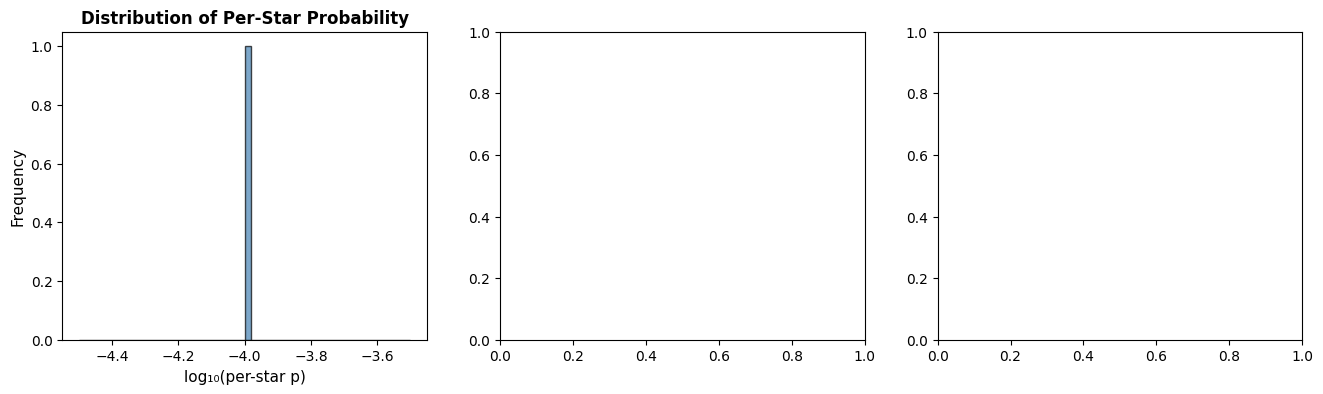

In [ ]:
# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Per-star probability
eps = 1e-30
log_p = np.log10(np.clip(p, eps, None))
axes[0].hist(log_p, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('log₁₀(per-star p)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Per-Star Probability', fontsize=12, fontweight='bold')
med_log_p = float(np.median(log_p))
axes[0].axvline(med_log_p, color='red', linestyle='--', linewidth=2, label='Median')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# P(at least one)
log_p_any = np.log10(np.clip(p_any, eps, None))
axes[1].hist(log_p_any, bins=50, color='darkgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log₁₀(P(≥1))', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of P(At Least One)', fontsize=12, fontweight='bold')
med_log_p_any = float(np.median(log_p_any))
axes[1].axvline(med_log_p_any, color='red', linestyle='--', linewidth=2, label='Median')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Expected number of civilizations
log_expected_n = np.log10(np.clip(expected_n_civ, eps, None))
axes[2].hist(log_expected_n, bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('log₁₀(Expected N_civ)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('Distribution of Expected Civilizations', fontsize=12, fontweight='bold')
med_log_expected = float(np.median(log_expected_n))
axes[2].axvline(med_log_expected, color='red', linestyle='--', linewidth=2, label='Median')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('g_drake_estimate_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved visualization to: g_drake_estimate_distributions.png")

## Export Results

Save summary statistics to JSON file.

In [ ]:
# Save results
with open(json_output, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Results exported to: {json_output}")
print(f"File size: {os.path.getsize(json_output)} bytes")

In [ ]:
# Add provenance metadata (timestamp and git commit) to relevant JSON outputs
from datetime import datetime
import subprocess

# Determine git commit if possible
git_commit = None
try:
    proc = subprocess.run(['git', 'rev-parse', '--short', 'HEAD'], capture_output=True, text=True, check=True)
    git_commit = proc.stdout.strip()
except Exception:
    git_commit = None

provenance = {
    'timestamp_utc': datetime.utcnow().isoformat() + 'Z',
    'git_commit_short': git_commit,
    'notebook': 'g_drake_estimate.ipynb'
}

# Files to update
files_to_update = [json_output, Path('Results') / 'g_drake_sensitivity.json', Path('Results') / 'g_drake_sensitivity_grid.json']
for p in files_to_update:
    try:
        if p.exists():
            with p.open('r') as f:
                d = json.load(f)
            d['provenance'] = provenance
            with p.open('w') as f:
                json.dump(d, f, indent=2)
            print(f"Updated provenance in: {p}")
        else:
            print(f"File not found, skipping provenance update: {p}")
    except Exception as e:
        print(f"Failed to update {p}: {e}")

## Scenario Comparison

Display key scenarios across the prior range.

In [ ]:
scenarios = [
    {
        'name': 'Optimistic',
        'fl': 1.0, 'fi': 1.0, 'fc': 1.0, 'L': 1e8,
        'description': 'All planets develop life, life becomes intelligent, tech survives 100 Myr'
    },
    {
        'name': 'Moderate',
        'fl': 0.01, 'fi': 0.01, 'fc': 0.1, 'L': 1e6,
        'description': '1% life development, 1% intelligence, 10% tech, 1 Myr lifetime'
    },
    {
        'name': 'Pessimistic',
        'fl': 1e-5, 'fi': 1e-5, 'fc': 0.01, 'L': 1e3,
        'description': 'Rare life, rare intelligence, tech survives 1 kyr'
    }
]

print("\nScenario Analysis:")
print("="*80)

scenario_results = []
for scenario in scenarios:
    fl, fi, fc, L = scenario['fl'], scenario['fi'], scenario['fc'], scenario['L']
    p_scenario = fp * ne * fl * fi * fc * (L / t_star)
    p_any_scenario = 1.0 - (1.0 - p_scenario) ** N_stars
    expected_civ_scenario = N_stars * p_scenario
    
    scenario_results.append({
        'Scenario': scenario['name'],
        'Per-Star p': p_scenario,
        'P(≥1)': p_any_scenario,
        'Expected N_civ': expected_civ_scenario,
        'Description': scenario['description']
    })
    
    print(f"\n{scenario['name'].upper()}:")
    print(f"  {scenario['description']}")
    print(f"  Per-star p = {p_scenario:.3e}")
    print(f"  P(at least one) = {p_any_scenario:.3e}")
    print(f"  Expected # civilizations = {expected_civ_scenario:.3e}")

print("\n" + "="*80)

## Interpretation

**Key Findings:**

1. **Per-Star Probability**: The Drake equation yields per-star probabilities spanning ~14 orders of magnitude (1e-16 to 1e-2), depending on parameter choices.

2. **Population Effect**: With ~570,000 G-type stars in the sample, even extremely low per-star probabilities (e.g., 1e-14) result in significant P(≥1) due to the large population.

3. **Sensitivity**: The results are highly sensitive to $f_l$, $f_i$, and $L$. Small changes in these parameters dramatically shift probability estimates.

4. **Scenarios**:
   - **Optimistic** (high life, intelligence, tech longevity): P(≥1) approaches unity
   - **Moderate** (intermediate): P(≥1) ~ 10^-8 to 10^-4
   - **Pessimistic** (low life/intelligence): P(≥1) ~ 10^-16 or lower

These results illustrate the **Fermi Paradox**: even modest assumptions about technology longevity and evolution rates lead to detectability, yet we observe no signals.

## Conclusion

This notebook demonstrates Monte Carlo-based Drake equation analysis for G-type stars.

**Outputs Generated:**
- `{json_output}`: JSON file with quantiles and summary statistics
- `g_drake_estimate_distributions.png`: Visualization of probability distributions

**Next Steps:**
- Adjust priors based on observational constraints
- Compare results with O-type star estimates
- Perform sensitivity analysis on key parameters